# Making an initial condition for MOM5 passive tracers
This notebook makes a restart and mask file for 4 Antarctic DSW tracers in:
* The Ross Sea (ross)
* The Weddell Sea (weddell)
* Prydz Bay (prydz)
* The Adelie Coast (adelie)
We create both an initial condition and a mask, using an existing pair of files that *should* have the right structure, etc.

These passive files were most recently created for the `01deg_jra55v140_iaf_cycle3` from Dec 2020. 

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import cosima_cookbook as cc
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft

from dask.distributed import Client

In [2]:
client = Client(n_workers=16)
client

Client Scheduler: tcp://127.0.0.1:40401 Dashboard: /proxy/8787/status,Cluster Workers: 16 Cores: 48 Memory: 202.49 GB


In [3]:
session = cc.database.create_session()

## 1. Crib data structure from existing passive restart file  

We'll use this later for passive initial conditions

In [4]:
passive = xr.open_dataset('ocean_passive.res.nc').passive_ross
passive = passive*0.0

## 2. Grab bathymetry from an existing output file

We use this to make the 2D masks, which we then need to put onto the model restart and mask files afterwards.

In [5]:
expt = '01deg_jra55v13_ryf9091'
ht = cc.querying.getvar(expt,'ht',session,n=-1) 
mask_2d = ht.copy(deep=True).rename('mask_2d')
mask_2d = mask_2d/mask_2d

Create a mask for the Ross Sea region.

(-79.0, -70.0)

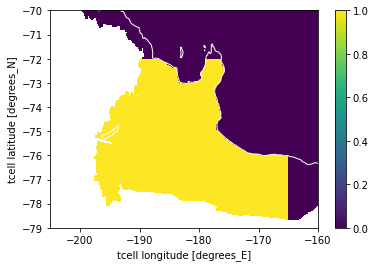

In [6]:
ross_mask_2d = mask_2d.copy(deep=True).rename('ross_mask_2d')
ross_mask_2d = ross_mask_2d.where((ht.yt_ocean<-72)&(ht.xt_ocean>-200)&(ht.xt_ocean<-165)&((ht<1000)|(ht.xt_ocean<-193)), 0.0)*mask_2d
ross_mask_2d.plot()
ht.plot.contour(levels=[1000],linewidths=1,colors='w')
plt.xlim([-205, -160])
plt.ylim([-79,-70])

Create a mask for the Weddell Sea region

(-80.0, -68.0)

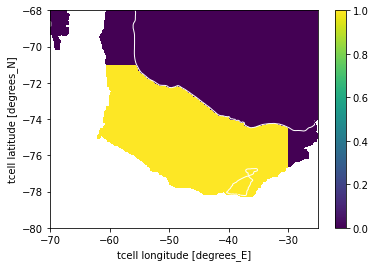

In [7]:
weddell_mask_2d = mask_2d.copy(deep=True).rename('weddell_mask_2d')
weddell_mask_2d = weddell_mask_2d.where((ht.yt_ocean<-71)&(ht.xt_ocean>-65)&(ht.xt_ocean<-30)&((ht<1000)|(ht.yt_ocean<-75)), 0.0)*mask_2d
weddell_mask_2d.plot()
ht.plot.contour(levels=[1000],linewidths=1,colors='w')
plt.xlim([-70, -25])
plt.ylim([-80,-68])

Create a mask for the Prydz Bay region - noting that this requires two patches as it straddles the zonal boundary of the ocean.

(-70.0, -63.0)

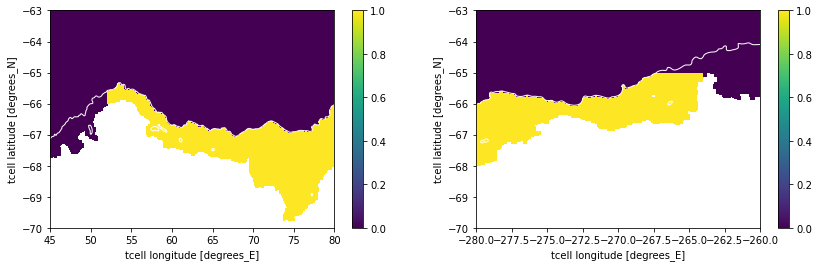

In [8]:
prydz_mask_2d = mask_2d.copy(deep=True).rename('prydz_mask_2d')
prydz_mask_2d = prydz_mask_2d.where((ht.yt_ocean<-65)&((ht.xt_ocean<-264)|(ht.xt_ocean>52))&((ht<1000)|(ht.yt_ocean<-67.1)), 0.0)*mask_2d
prydz_mask_2d = prydz_mask_2d.where((ht.yt_ocean>-65.5)|(ht.xt_ocean<-267)|(ht.xt_ocean>-265), 1.0)*mask_2d
prydz_mask_2d = prydz_mask_2d.where((ht.yt_ocean>-66.5)|(ht.xt_ocean>59.5)|(ht.xt_ocean<56), 1.0)*mask_2d
plt.figure(figsize=(14,4))
plt.subplot(121)
prydz_mask_2d.plot()
ht.plot.contour(levels=[1000],linewidths=1,colors='w')
plt.xlim([45, 80])
plt.ylim([-70,-63])
plt.subplot(122)
prydz_mask_2d.plot()
ht.plot.contour(levels=[1000],linewidths=1,colors='w')
plt.xlim([-280,-260])
plt.ylim([-70,-63])

Create a mask for the Adelie coast.

(-70.0, -63.0)

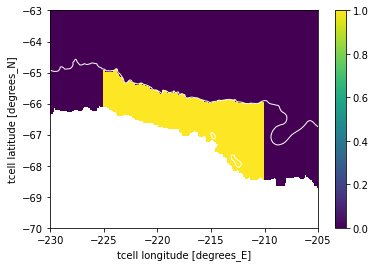

In [9]:
adelie_mask_2d = mask_2d.copy(deep=True).rename('adelie_mask_2d')
adelie_mask_2d = adelie_mask_2d.where((ht.xt_ocean>-225)&(ht.xt_ocean<-210)&(ht.yt_ocean<-64.5)&((ht<1000)|(ht.yt_ocean<-66.5)), 0.0)*mask_2d
adelie_mask_2d.plot()
ht.plot.contour(levels=[1000],linewidths=1,colors='w')
plt.xlim([-230, -205])
plt.ylim([-70,-63])

Plot all four regions on one map for checking purposes.

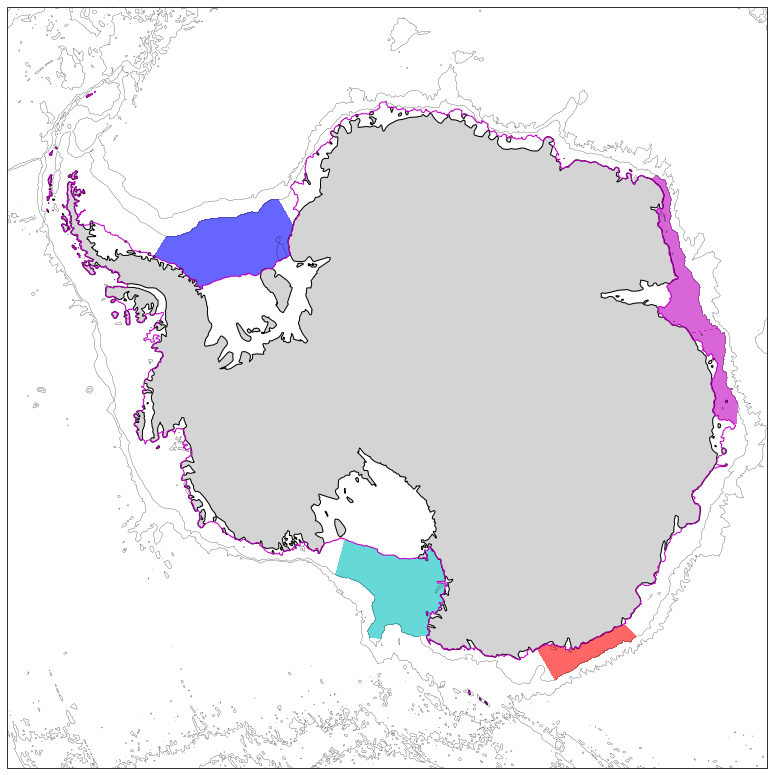

In [10]:
fig = plt.figure(num=1,figsize=(14, 14))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.coastlines(resolution='50m') # add coastlines
ax.add_feature(cft.LAND,color=[.83, .83, .83]) # grey land colour

ross_mask_2d.plot.contourf(ax=ax, levels=[0.5,1.5], colors=['c','k'], alpha = 0.6, add_colorbar=False, extend='max',transform=ccrs.PlateCarree())
adelie_mask_2d.plot.contourf(ax=ax, levels=[0.5,1.5], colors=['r','k'], alpha = 0.6, add_colorbar=False,extend='max', transform=ccrs.PlateCarree())
prydz_mask_2d.plot.contourf(ax=ax, levels=[0.5,1.5], colors=['m','k'], alpha = 0.6, add_colorbar=False,extend='max', transform=ccrs.PlateCarree())
weddell_mask_2d.plot.contourf(ax=ax, levels=[0.5,1.5], colors=['b','k'], alpha = 0.6, add_colorbar=False,extend='max', transform=ccrs.PlateCarree())

ht.fillna(0.0).plot.contour(levels=[0],linewidths=1,colors='m',transform=ccrs.PlateCarree())
ht.plot.contour(levels=[1000,3000],linewidths=0.25,colors='k',transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -63], ccrs.PlateCarree())

**We now have the 2D structure of our mask and our initial conditions.**
The next job is to fill out 4D arrays to get these values correct..

## 3. Make initial condition for each case

The tracer should be zero over most of the domain. In the region where tracer is restored, we set tracer to 1.0 at the surface, quadratically decaying with depth in that water column -- this is just to ensure vertical gradients are sufficiently weak to guarantee numerical stability.

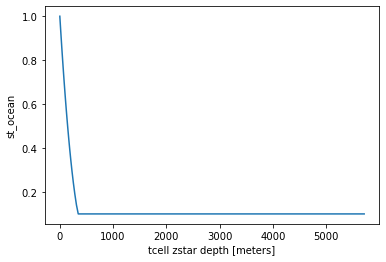

In [11]:
st_ocean = cc.querying.getvar(expt,'st_ocean',session,n=-1).st_ocean
zfactor = ((500-st_ocean)/500)**2
zfactor = zfactor.where(st_ocean<340,0.1)
zfactor.plot()

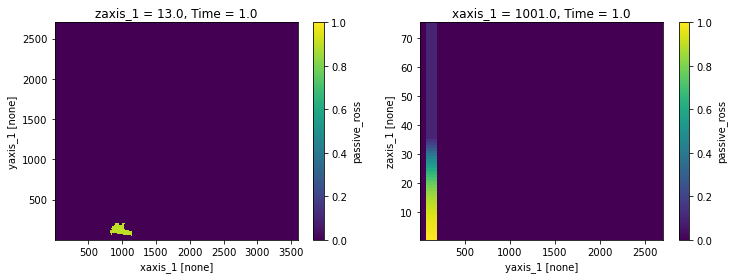

In [12]:
passive_ross = passive.copy(deep=True)
ross_3d = zfactor*ross_mask_2d.fillna(0)
passive_ross[0,:,:,:] = ross_3d.values
plt.figure(figsize=(12,4))
plt.subplot(121)
passive_ross.isel(zaxis_1=12).plot(vmax=1)
plt.subplot(122)
passive_ross.isel(xaxis_1=1000).plot(vmax=1)

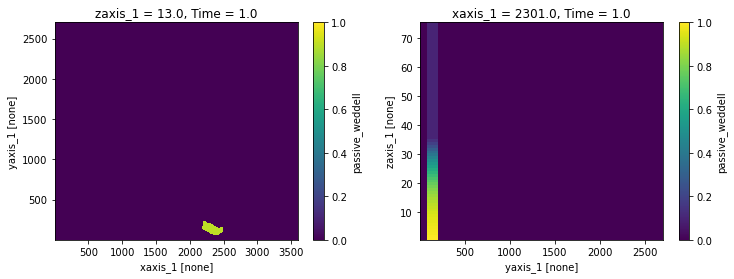

In [13]:
passive_weddell = passive.copy(deep=True).rename('passive_weddell')
weddell_3d = zfactor*weddell_mask_2d.fillna(0)
passive_weddell[0,:,:,:] = weddell_3d.values
plt.figure(figsize=(12,4))
plt.subplot(121)
passive_weddell.isel(zaxis_1=12).plot(vmax=1)
plt.subplot(122)
passive_weddell.isel(xaxis_1=2300).plot(vmax=1)

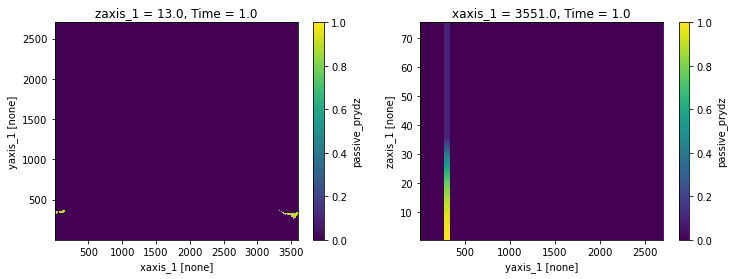

In [14]:
passive_prydz = passive.copy(deep=True).rename('passive_prydz')
prydz_3d = zfactor*prydz_mask_2d.fillna(0)
passive_prydz[0,:,:,:] = prydz_3d.values
plt.figure(figsize=(12,4))
plt.subplot(121)
passive_prydz.isel(zaxis_1=12).plot(vmax=1)
plt.subplot(122)
passive_prydz.isel(xaxis_1=3550).plot(vmax=1)

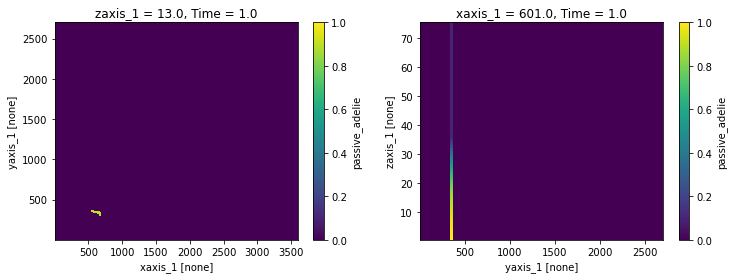

In [15]:
passive_adelie = passive.copy(deep=True).rename('passive_adelie')
adelie_3d = zfactor*adelie_mask_2d.fillna(0)
passive_adelie[0,:,:,:] = adelie_3d.values
plt.figure(figsize=(12,4))
plt.subplot(121)
passive_adelie.isel(zaxis_1=12).plot(vmax=1)
plt.subplot(122)
passive_adelie.isel(xaxis_1=600).plot(vmax=1)

## 4. Merge and save to netcdf

Save a file with each of these passive_* variables present. This will form the initial condition file for an existing simulation - so is a restart file.

In [17]:
fourtracers = xr.merge([passive_ross, passive_weddell, passive_prydz, passive_adelie])
fourtracers.to_netcdf('passive4/ocean_passive.res.nc')

## 5. Make masks

Use existing passive_rossmask file from a previous run to make generic passive mask which is active at the surface in the region of interest and zero elsewhere.

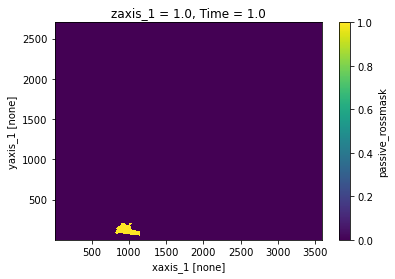

In [16]:
passive_mask = xr.open_dataset('ocean_passive_masks.res.nc').passive_rossmask
passive_mask = passive_mask*0.0
passive_rossmask = passive_mask.copy(deep=True).rename('passive_rossmask')
passive_rossmask[0,0,:,:]=ross_mask_2d.fillna(0).values
passive_rossmask.isel(zaxis_1=0).plot()

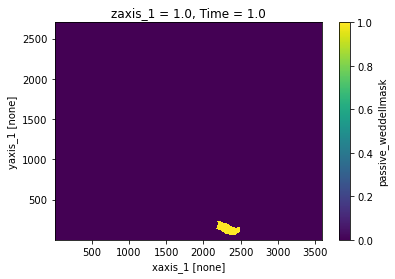

In [17]:
passive_weddellmask = passive_mask.copy(deep=True).rename('passive_weddellmask')
passive_weddellmask[0,0,:,:]=weddell_mask_2d.fillna(0).values
passive_weddellmask.isel(zaxis_1=0).plot()

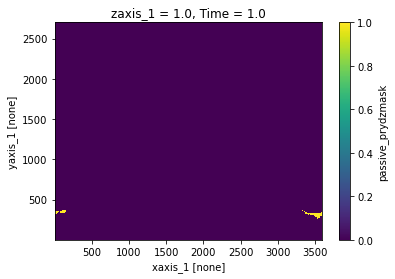

In [18]:
passive_prydzmask = passive_mask.copy(deep=True).rename('passive_prydzmask')
passive_prydzmask[0,0,:,:]=prydz_mask_2d.fillna(0).values
passive_prydzmask.isel(zaxis_1=0).plot()

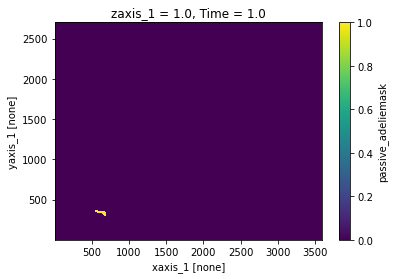

In [19]:
passive_adeliemask = passive_mask.copy(deep=True).rename('passive_adeliemask')
passive_adeliemask[0,0,:,:]=adelie_mask_2d.fillna(0).values
passive_adeliemask.isel(zaxis_1=0).plot()

Save these to a file - although we didn't actually use the inbuilt restoring in these runs, as we used the sponge version instead (See 6).

In [22]:
fourmasks = xr.merge([passive_rossmask, passive_weddellmask, passive_prydzmask, passive_adeliemask])
fourmasks.to_netcdf('passive4/ocean_passive_masks.res.nc')

# 6. Make sponge files
These are needed to damp the passive tracer to zero in the surface layer outside the masked region. Firstly, need to attend to some time attribute details.

In [20]:
passive_ross.Time.attrs["units"]= "days since 1900-01-01"
passive_ross.Time.attrs["calendar"] = "gregorian"
passive_weddell.Time.attrs["units"]= "days since 1900-01-01"
passive_weddell.Time.attrs["calendar"] = "gregorian"
passive_prydz.Time.attrs["units"]= "days since 1900-01-01"
passive_prydz.Time.attrs["calendar"] = "gregorian"
passive_adelie.Time.attrs["units"]= "days since 1900-01-01"
passive_adelie.Time.attrs["calendar"] = "gregorian"

Trying to make sponges to restore to passive_* fields.

In [ ]:
encoding = {'passive_ross': {'_FillValue': 1e20}}
passive_ross.to_netcdf('passive4/passive_ross_sponge.nc',unlimited_dims='Time',encoding=encoding)
encoding = {'passive_weddell': {'_FillValue': 1e20}}
passive_weddell.to_netcdf('passive4/passive_weddell_sponge.nc',unlimited_dims='Time',encoding=encoding)
encoding = {'passive_prydz': {'_FillValue': 1e20}}
passive_prydz.to_netcdf('passive4/passive_prydz_sponge.nc',unlimited_dims='Time',encoding=encoding)
encoding = {'passive_adelie': {'_FillValue': 1e20}}
passive_adelie.to_netcdf('passive4/passive_adelie_sponge.nc',unlimited_dims='Time',encoding=encoding)

I need a coeff file which is zero everywhere except for surface ocean points which are 1/86400.
Needs no time dimension.

In [21]:
coeff_2d = mask_2d.fillna(0).copy(deep=True).rename('coeff_2d')
coeff_2d = coeff_2d/1000.
coeff = passive_mask.copy(deep=True).rename('coeff').squeeze()
coeff[0,:,:] = coeff_2d.values

coeff.to_netcdf('passive4/passive_ross_sponge_coeff.nc')
coeff.to_netcdf('passive4/passive_weddell_sponge_coeff.nc')
coeff.to_netcdf('passive4/passive_prydz_sponge_coeff.nc')
coeff.to_netcdf('passive4/passive_adelie_sponge_coeff.nc')

# turn 3d sponge restoring on

## 7. From here you will need to:
* Alter config.yaml to pick up this netcdf file. Something like:

```      
    input:
       	  - /g/data/ik11/inputs/access-om2/input_08022019/mom_01deg
             - /g/data/THIS LOCATION
```         

* Add new entries to the `field_table` to activate the passive tracers. I used:

```
"tracer_packages","ocean_mod","ocean_passive"
names = ross, weddell, prydz, adelie
const_init_tracer = .false.
horizontal-advection-scheme = mdppm
vertical-advection-scheme = mdppm
ppm_hlimiter = 3
ppm_vlimiter = 3
restart_file = ocean_passive.res.nc
min_tracer_limit=0.0
/
```
* And, a bit later on in the `field_table` turn the sponge restoring on
```
"namelists","ocean_mod","ocean_passive/ross"
restore	= .true.
"namelists","ocean_mod","ocean_passive/weddell"
restore	= .true.
"namelists","ocean_mod","ocean_passive/prydz"
restore	= .true.
"namelists","ocean_mod","ocean_passive/adelie"
restore	= .true.
/
```

* Turn on the damping in `input.nml`:
```
&ocean_sponges_tracer_nml
    use_this_module   = .false.
/
```

* Add diagnostic output for the tracers to the diag_table

``` 
## Andy's new tests with passive tracers:
"ocean_passive_tracers", 1,  "months", 1, "days", "time",
...
"ocean_model","passive_ross","passive_ross","ocean_passive_tracers","all",.true.,"none",2
"ocean_model","passive_weddell","passive_weddell","ocean_passive_tracers","all",.true.,"none",2
"ocean_model","passive_prydz","passive_prydz","ocean_passive_tracers","all",.true.,"none",2
"ocean_model","passive_adelie","passive_adelie","ocean_passive_tracers","all",.true.,"none",2
```
